# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [80]:
# Import necessary libraries.

import pandas as pd
import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings("ignore")


In [81]:
# Load zillow_data.csv into a data frame.
df = pd.io.parsers.read_csv('zillow_data.csv', dtype={'RegionName': 'str'})

In [82]:
# Check the data frame loaded properly.

df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(48), object(5)
memory usage: 30.6+ MB


# Step 2: Data Preprocessing

In [84]:
# Create a function to format time columns.

def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

# Step 3: Reshape from Wide to Long Format

In [85]:
# Create function to reshape the data frame with a time column.

def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName', 'RegionID', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [86]:
# Melted the data frame.
df = melt_data(df)

In [87]:
# Rename RegionName to ZipCode and drop RegionID, SizeRank, and Metro.
df.rename(columns={'RegionName': 'ZipCode'}, inplace = True)

In [88]:
df = df.pivot_table(index='time', columns ='ZipCode', values = 'value')
df.head()

ZipCode,01001,01002,01005,01007,01008,01010,01011,01013,01020,01026,...,99654,99664,99669,99701,99705,99709,99712,99801,99835,99901
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,113100.0,161000.0,103100.0,133400.0,117500.0,115800.0,87000.0,88500.0,97200.0,91200.0,...,122700.0,112200.0,112500.0,89400.0,101900.0,103000.0,109200.0,166800.0,155500.0,117100.0
1996-05-01,112800.0,160100.0,103400.0,132700.0,117300.0,115700.0,87000.0,88500.0,97100.0,91100.0,...,124200.0,112400.0,113100.0,89800.0,102900.0,103900.0,109600.0,166200.0,154900.0,117200.0
1996-06-01,112600.0,159300.0,103600.0,132000.0,117100.0,115500.0,87100.0,88400.0,97000.0,91000.0,...,125700.0,112600.0,113800.0,90200.0,103800.0,104700.0,110000.0,165400.0,154200.0,117300.0
1996-07-01,112300.0,158600.0,103800.0,131400.0,117000.0,115300.0,87200.0,88300.0,96800.0,90800.0,...,127200.0,112800.0,114400.0,90600.0,104700.0,105500.0,110400.0,164400.0,153500.0,117400.0
1996-08-01,112100.0,158000.0,103900.0,130800.0,116800.0,115100.0,87400.0,88200.0,96600.0,90700.0,...,128600.0,113000.0,115100.0,91000.0,105400.0,106200.0,110800.0,163500.0,152800.0,117500.0


In [132]:
df['10021'].isna().sum()

93

In [116]:
#Find average of each zipcode to select
# sorted(np.mean(df))

In [90]:
new_df = pd.DataFrame(df.mean().to_dict(),index=[df.index.values[-1]])
new_df.head()

,01001,01002,01005,01007,01008,01010,01011,01013,01020,01026,...,99654,99664,99669,99701,99705,99709,99712,99801,99835,99901
2018-04-01,174509.811321,273152.45283,172650.943396,217938.113208,175319.622642,198326.037736,135570.566038,138181.132075,148291.320755,167812.830189,...,210570.188679,178592.45283,195283.018868,171467.924528,206160.377358,209635.09434,217032.075472,290029.433962,273726.415094,216198.490566


In [109]:
#df.mean().sort_values(ascending = False)

In [129]:
def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame

In [133]:
# column_names = ['10021', '10011', '10014', '10128', '94027']
# select_columns(df, column_names)

In [134]:
#highest_ZipCodes.isna()

In [139]:
column_names = ['10128', '94027']
dataframe = select_columns(df, column_names)

In [158]:
dataframe.head()

ZipCode,10128,94027
time,,
1996-04-01,3676700.0,1179200.0
1996-05-01,3704200.0,1184300.0
1996-06-01,3729600.0,1189700.0
1996-07-01,3754600.0,1195400.0
1996-08-01,3781800.0,1201200.0


# Step 4: EDA and Visualization
Perform basic EDA as you would building any model, then create at least 3 visualizations.  At least one of the visualizations should have time on the x-axis.  Axes should be labeled and any text should be legible.

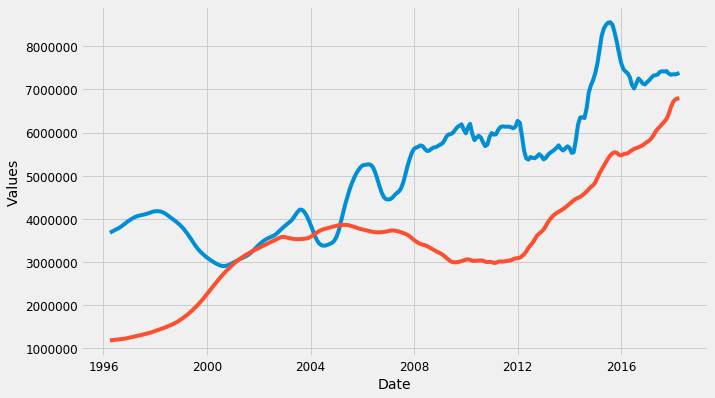

In [141]:
plt.xlabel('Date')
plt.ylabel('Values')
plt.plot(dataframe)

In [156]:
#check stationary function 

def test_stationarity(timeseries):
    
    #Determine rolling statistis
    rolMean = timeseries.rolling(window=12).mean()
    rolStd = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics 
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolMean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolStd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Moving Average & Standard Deviation')
    plt.show(block = False)
    
    #Perform dickey-fuller test 
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(dataframe[['value']], autolag ='AIC')
    dfoutput =pdSeries(dftest[0:4], index = ['Test Statistic', 'P Value', 'Lags Used', 'Number of Observations Used'])
    for key.value in dftest[4].items():
        dfoutput['Critical Value (%s)'%ky] = value
    print(dfoutput)

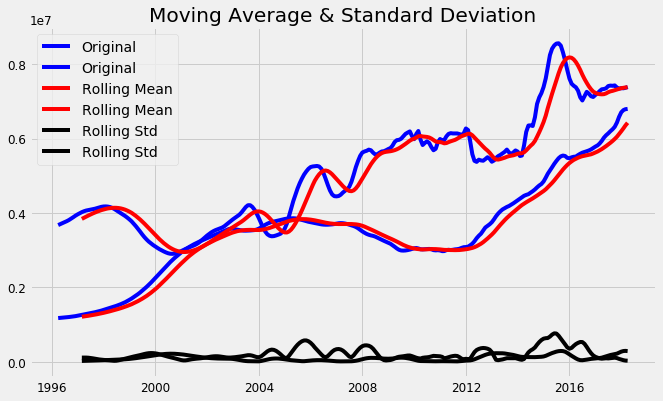

Results of Dickey-Fuller Test:


ValueError: too many values to unpack (expected 2)

In [157]:
test_stationarity(dataframe)

In [ ]:
#Estimating trend by taking log 
dataframe_logScale = np.log(dataframe)
plt.plt(dataframe_logScale)

In [21]:
#ACF and PACF plots 
lag_acf = acf(dataframeLogScale, nlags = 20)
lag_pacf = pacf(dataframeLogScale, nlags = 20, method = 'ols')

#Plot ACF 
plt.subplot(121)
plt.plt(lag_acf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y=1.96/np/sqr(len(dataframeLogScale)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#Plot PACF 
plt.subplot(122)
plt.plt(lag_pacf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y=1.96/np/sqr(len(dataframeLogScale)), linestyle = '--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
#Check for where ACF & PACF cross x axis the first time to find p + q

# Step 5: ARIMA Modeling
Be sure to validate your model.  Make a forecast for the future and describe the trend.

In [77]:
#ARIMA model 

# model = ARIMA(dataframe_logScale, order(p,d,q))
# results_AR = model.fit(disp = -1)
# plt.plot(results_AR.fittedvalues.color ='red')
# plt.title('RSS:%4f%sum(results_AR.fittedcalues-datasetLogDiffShifting['values'])**2')
# print('Plotting AR Model')

In [78]:
#Predictions 
# predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
# print(predictions_ARIMA-diff.head())

# Step 6: Interpreting Results
Give a detailed interpretation of results including the relationship between the inputs and output of the model.